# **Tarea 1 - Deep Learning - César Núñez**

## **Montar Google Drive a Google Colab**

**Ejecutar las siguiente lineas de código solo si deseas guardar el módelo entrenado.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/DL_QLAB/Deep_Learning/Semana_2

/content/drive/MyDrive/DL_QLAB/Deep_Learning/Semana_2


## Cargando el conjunto de datos

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.utils import plot_model, to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
import scipy
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

from sklearn.utils import shuffle

Vamos a cargar el conjunto de datos.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Ahora crearemos tres conjuntos:
- Entrenamiento (train),
- Validación (validation),
- Pruebas (testing)

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  test_size=0.1)

print("Training: Data ({}), Labels ({})".format(x_train.shape, y_train.shape))
print("Validation: Data ({}), Labels ({})".format(x_val.shape, y_val.shape))
print("Testing: Data ({}), Labels ({})".format(x_test.shape, y_test.shape))

Training: Data ((54000, 28, 28)), Labels ((54000,))
Validation: Data ((6000, 28, 28)), Labels ((6000,))
Testing: Data ((10000, 28, 28)), Labels ((10000,))


### **Preprocesamiento**

In [4]:
# (#,28,28) => (#,28,28,1)
# uint8 => float
# [0,255] => [0,1]
x_train = np.expand_dims(x_train, axis=-1).astype("float32")/255.0
x_val = np.expand_dims(x_val, axis=-1).astype("float32")/255.0
x_test = np.expand_dims(x_test, axis=-1).astype("float32")/255.0

In [5]:
name_labels = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

n_classes = len(name_labels)

### **Visualización**

Veamos algunas muestras del conjunto de datos

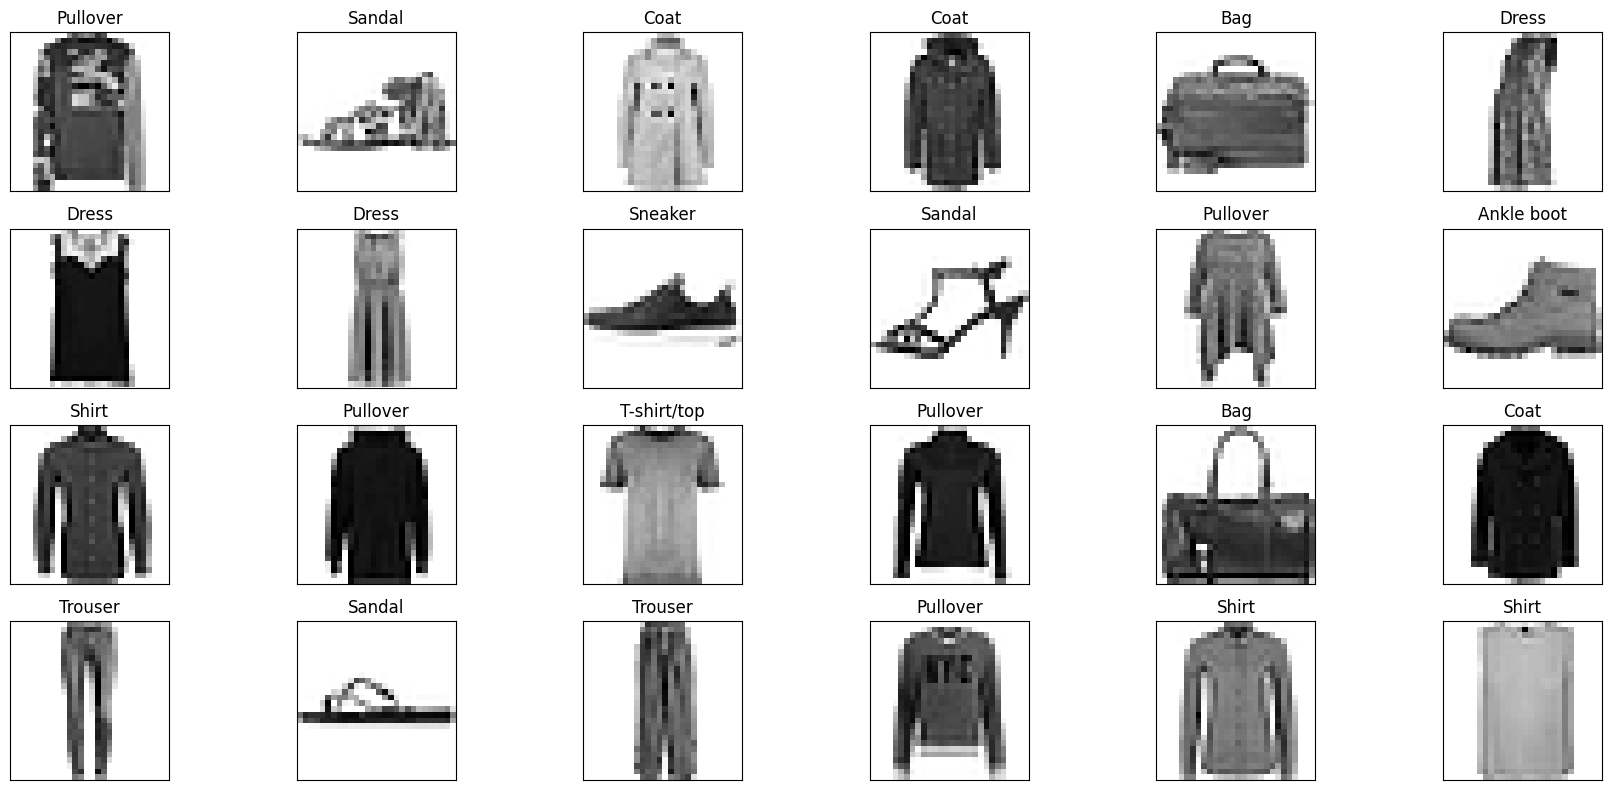

In [6]:
rows = 4
columns = 6
n = rows*columns

images = x_train[:n]
labels = y_train[:n]

fig, axes = plt.subplots(rows,
                         columns,
                         figsize=(3*columns,2*rows))

for i in range(n):
  ax = axes[i//columns, i%columns]
  ax.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)
  ax.set_title('{}'.format(name_labels[labels[i]]))
  ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

### **Generador de datos**

Con la clase [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) podemos aplicar diferentes transformaciones para el aumento de datos (_data augmentation_)

In [7]:
batch_size = 32

# Generador para Entrenamiento, con flips horizontal y vertical
gen_train = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True)
# Generador para Validación
gen_val = ImageDataGenerator()

data_gen_train = gen_train.flow(x_train,
                                y_train,
                                batch_size=batch_size)

data_gen_val = gen_val.flow(x_val,
                            y_val,
                            batch_size=batch_size)

**Preguntas:**
- ¿Aplicamos aumento de datos (data augmentation) en el conjunto de validación?
- ¿Aplicamos aumento de datos (data augmentation) en el conjunto de pruebas (test)?

Tambien podemos visualizar la salida del generador de datos luego de aplicar aumento de datos.

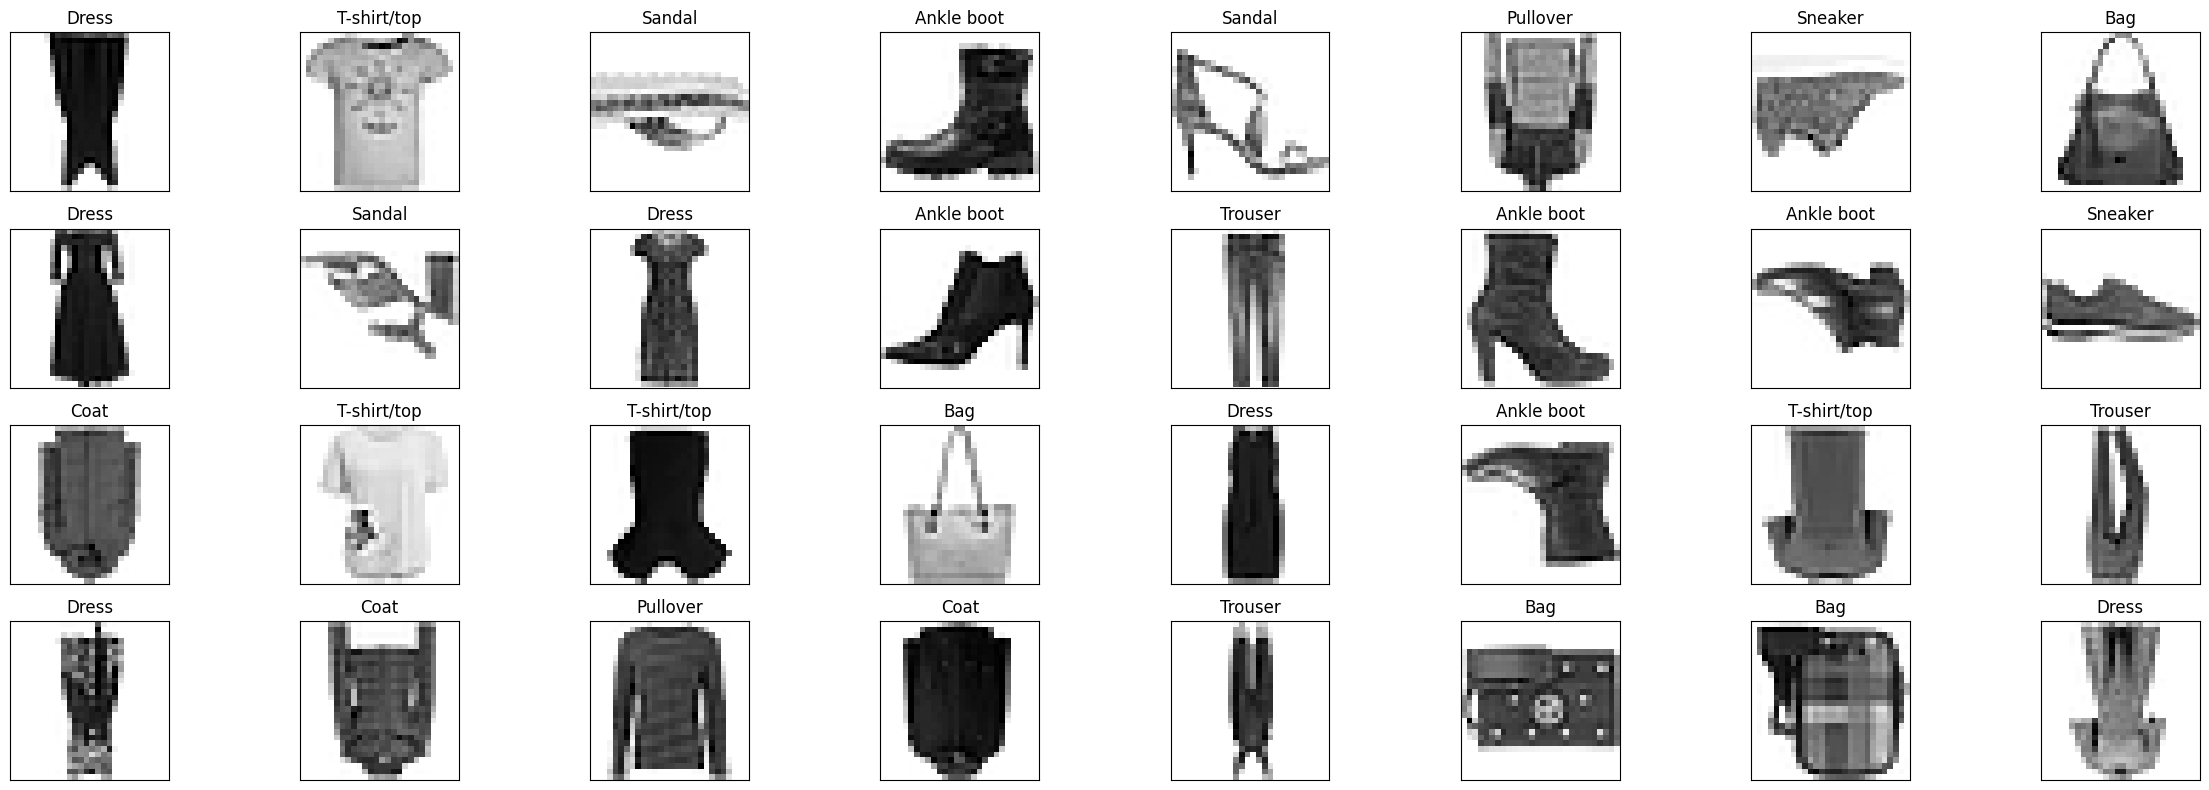

In [8]:
x_batch, y_batch = data_gen_train.next()

rows = 4
columns = 8
n = rows*columns

fig, axes = plt.subplots(rows,
                         columns,
                         figsize=(3*columns,2*rows))

for i in range(n):
  ax = axes[i//columns, i%columns]
  ax.imshow(x_batch[i].reshape(28,28), cmap=plt.cm.binary)
  ax.set_title('{}'.format(name_labels[y_batch[i]]))
  ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

# API
Para esta tarea se busca identificar si existen diferencias en tres aspectos: 
1. Tipos de optimizadores. En específico se utilizarán Stocastic Gradient Descent (SGD), SGD con mometum, Adaptive Moment Estimation (Adam) y AdaGrad (una variante del optimizador Adam)
2. Diferentes grupos de capas convolucionales conjuntas. En específico, se probarán tres tipos de secuencias: (i) 3 capas convolucionales seguidas, (ii) 2 capas convolucionales seguidas, 1 pooling y 1 capa convolucional, (iii) 1 capa convolucional, 1 pooling, 1 capa convolucional, 1 pooling, 1 última capa convolucional.
3. Diferentes learning rates

In [9]:
# Using Functional API
def get_model_funct(filters,
                    n_classes,
                    k=3,
                    name="my_model",
                    padding="same",
                    batch_norm=False,
                    dropout=None,
                    optimizer="Adam",
                    learning_rate=0.001,
                    structure=0):
    input_layer = Input(shape=(28,28,1))

    if structure ==1:
    # Estructura 3 convoluciones seguidas
        x = Conv2D(filters[0],
                   (k,k),
                   activation="relu",
                   padding=padding)(input_layer)
        x = Conv2D(filters[1],
               (k,k),
               activation="relu",
               padding=padding)(x)
        x = Conv2D(filters[2],
               (k,k),
               activation="relu",
                   padding=padding)(x)
        # Batch normalization
        if batch_norm: x = BatchNormalization()(x)
        # Max pooling
        x = MaxPooling2D(2,2)(x)
        # Dropout
        if dropout is not None: x = Dropout(dropout)(x)
    
    elif structure ==2:
    # 2 capas convolucionales seguidas, 1 pooling y 1 capa convolucional final    
        # Convolutional block 1 y 2
        x = Conv2D(filters[0],
                   (k,k),
                   activation="relu",
                   padding=padding)(input_layer)
        x = Conv2D(filters[1],
                   (k,k),
                   activation="relu",
                   padding=padding)(x)
        # Batch normalization
        if batch_norm: x = BatchNormalization()(x)
        # Max pooling
        x = MaxPooling2D(2,2)(x)
        # Dropout
        if dropout is not None: x = Dropout(dropout)(x)

        # Convolutional block 3
        x = Conv2D(filters[2],
                   (k,k),
                   activation="relu",
                   padding=padding)(x)

        # Batch normalization
        if batch_norm: x = BatchNormalization()(x)
        # Max pooling
        x = MaxPooling2D(2,2)(x)
        # Dropout
        if dropout is not None: x = Dropout(dropout)(x)

    else:
        # 3 capas convolucionales intercaladas entre poolings 
        # Convolutional block 1
        x = Conv2D(filters[0],
                   (k,k),
                   activation="relu",
                   padding=padding)(input_layer)
        # Batch normalization
        if batch_norm: x = BatchNormalization()(x)
        # Max pooling
        x = MaxPooling2D(2,2)(x)
        # Dropout
        if dropout is not None: x = Dropout(dropout)(x)

        # Convolutional block 2
        x = Conv2D(filters[1],
                   (k,k),
                   activation="relu",
                   padding=padding)(x)
        # Batch normalization
        if batch_norm: x = BatchNormalization()(x)
        # Max pooling
        x = MaxPooling2D(2,2)(x)
        # Dropout
        if dropout is not None: x = Dropout(dropout)(x)

        # Convolutional block 3
        x = Conv2D(filters[2],
                   (k,k),
                   activation="relu",
                   padding=padding)(x)
        # Batch normalization
        if batch_norm: x = BatchNormalization()(x)
        # Max pooling
        x = MaxPooling2D(2,2)(x)
        # Dropout
        if dropout is not None: x = Dropout(dropout)(x)
        
    x = Flatten()(x)
    # Dense layers
    x = Dense(100,
              activation="relu")(x)
    output_layer = Dense(n_classes,
                         activation="softmax")(x)
    # Modelo final
    model = Model(inputs=input_layer, outputs=output_layer, name=name)

    # Configuración del modelo
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy']
                  )
    # Configuración del modelo
    if optimizer == "Adam":
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy']
                      )
    elif optimizer == "SGD":
        model.compile(optimizer=SGD(learning_rate=learning_rate),
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy']
                      )
    elif optimizer == "SGDcM":
        model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=0.1),
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy']
                      )
    else:
        model.compile(optimizer=Adagrad(learning_rate=learning_rate),
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy']
                      )
    return model

# 1. Variantes del modelo según optimizadores

In [10]:
model_cnn_1 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_1_SGD",
                              optimizer="SGD",
                              learning_rate=0.001,
                              structure=1,
                              batch_norm=True,
                              dropout=0.3)

model_cnn_2 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_2_SGDcMomentum",
                              optimizer="SGDcM",
                              learning_rate=0.001,
                              structure=1,
                              batch_norm=True,
                              dropout=0.3)

model_cnn_3 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_3_Adam",
                              optimizer="Adam",
                              learning_rate=0.001,
                              structure=1,
                              batch_norm=True,
                              dropout=0.3)

model_cnn_4 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_4_Adagrad",
                              optimizer="Adagrad",
                              learning_rate=0.001,
                              structure=1,
                              batch_norm=True,
                              dropout=0.3)


In [12]:
model_cnn_1.summary()
print("\n\n")
model_cnn_2.summary()
print("\n\n")
model_cnn_3.summary()
print("\n\n")
model_cnn_4.summary()

Model: "CNN_1_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                      

In [13]:
print("Model:{}, Parameters:{}".format(model_cnn_1.name,
                                       model_cnn_1.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_2.name,
                                       model_cnn_2.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_3.name,
                                       model_cnn_3.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_4.name,
                                       model_cnn_4.count_params()))

Model:CNN_1_SGD, Parameters:647254
Model:CNN_2_SGDcMomentum, Parameters:647254
Model:CNN_3_Adam, Parameters:647254
Model:CNN_4_Adagrad, Parameters:647254


## 1.1. Visualización de los modelos

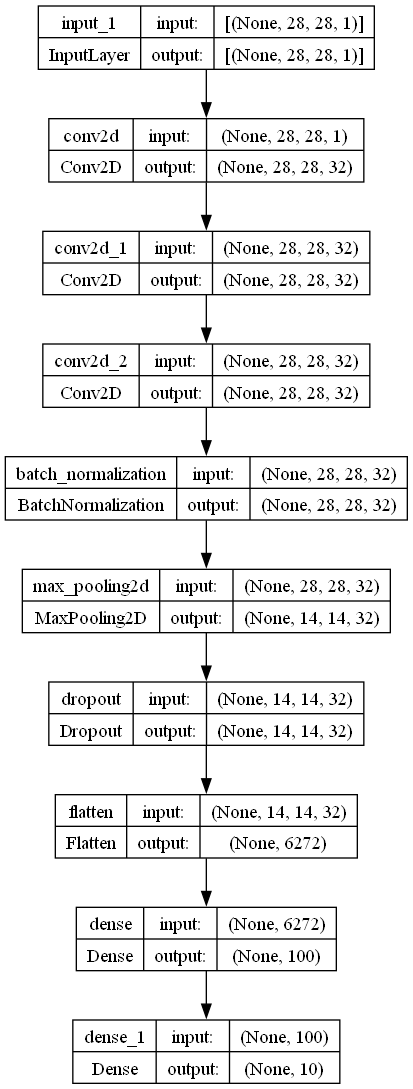

In [14]:
plot_model(model_cnn_1, to_file="model_cnn_1.png", show_shapes=True)

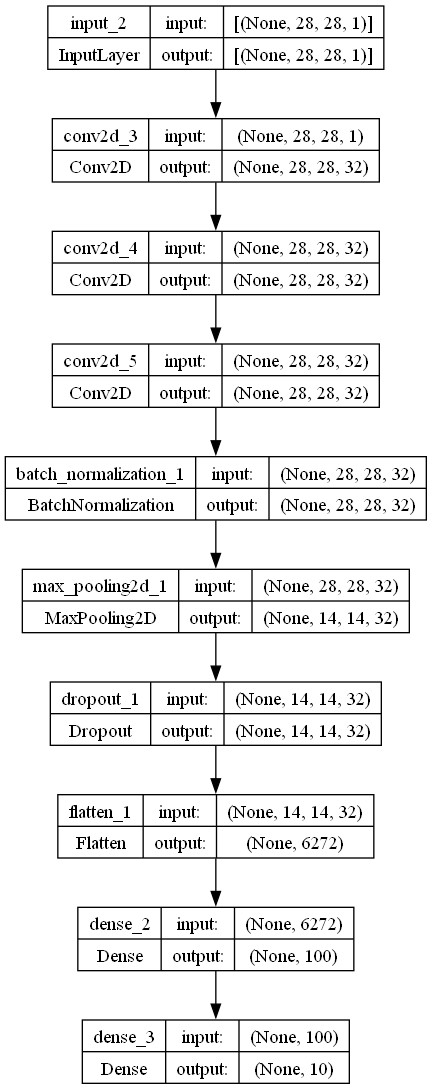

In [15]:
plot_model(model_cnn_2, to_file="model_cnn_2.png", show_shapes=True)

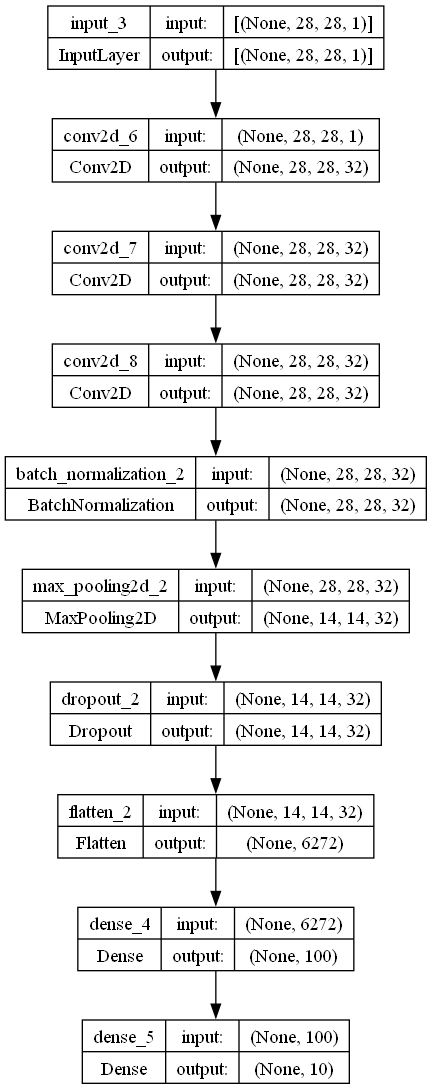

In [16]:
plot_model(model_cnn_3, to_file="model_cnn_3.png", show_shapes=True)

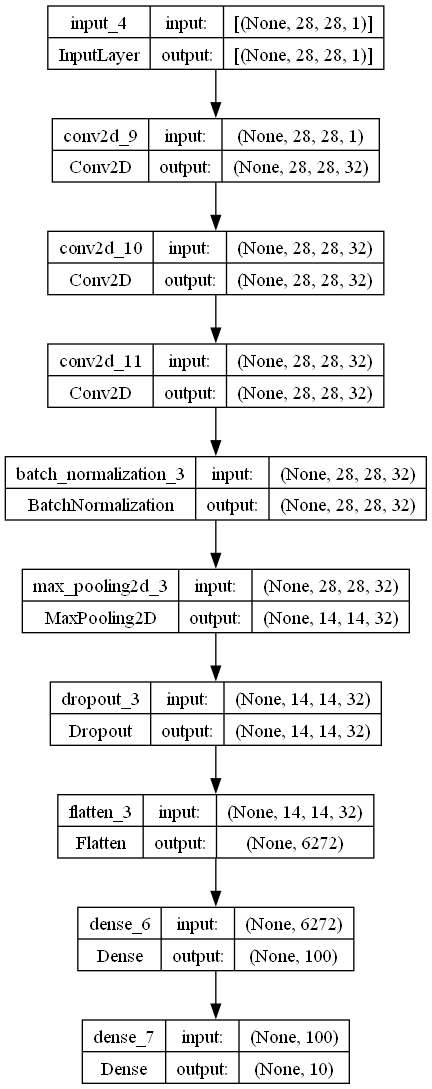

In [17]:
plot_model(model_cnn_4, to_file="model_cnn_4.png", show_shapes=True)

## 1.2. Entrenamiento del modelo

In [11]:
def get_ckpt(ckpt_name):
  return ModelCheckpoint(ckpt_name,
                         mode="max",
                         save_best_only=True,
                         monitor="val_accuracy",
                         verbose=1)

In [12]:
# Callbacks
# ModelCheckpoint guardara el modelo cada vez que exista una mejora
# en el accuracy del conjunto de validación
mode_autosave_cnn_1 = get_ckpt("classification_model_cnn_1.h5")
mode_autosave_cnn_2 = get_ckpt("classification_model_cnn_2.h5")
mode_autosave_cnn_3 = get_ckpt("classification_model_cnn_3.h5")
mode_autosave_cnn_4 = get_ckpt("classification_model_cnn_4.h5")

# EarlyStopping terminara el entrenamiento si no existe una mejora
# en el accuracy en 40 epocas
early_stopping = EarlyStopping(patience=40,
                               verbose=1,
                               mode="auto")

callbacks_cnn_1 = [mode_autosave_cnn_1, early_stopping]
callbacks_cnn_2 = [mode_autosave_cnn_2, early_stopping]
callbacks_cnn_3 = [mode_autosave_cnn_3, early_stopping]
callbacks_cnn_4 = [mode_autosave_cnn_4, early_stopping]

In [24]:
history_cnn_1 = model_cnn_1.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_1
                                )

Epoch 1/200
1688/1688 [==============================] - ETA: 0s - loss: 0.8889 - accuracy: 0.6856
Epoch 1: val_accuracy improved from -inf to 0.80300, saving model to classification_model_cnn_1.h5
1688/1688 [==============================] - 231s 137ms/step - loss: 0.8889 - accuracy: 0.6856 - val_loss: 0.5668 - val_accuracy: 0.8030
Epoch 2/200
1688/1688 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.7959
Epoch 2: val_accuracy improved from 0.80300 to 0.82667, saving model to classification_model_cnn_1.h5
1688/1688 [==============================] - 310s 184ms/step - loss: 0.5722 - accuracy: 0.7959 - val_loss: 0.4850 - val_accuracy: 0.8267
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.5041 - accuracy: 0.8184
Epoch 3: val_accuracy improved from 0.82667 to 0.84133, saving model to classification_model_cnn_1.h5
1688/1688 [==============================] - 211s 125ms/step - loss: 0.5041 - accuracy: 0.8184 - val_loss: 0.4417 - val_accura

In [21]:
history_cnn_2 = model_cnn_2.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_2
                                )

Epoch 1/200
1688/1688 [==============================] - ETA: 0s - loss: 0.8414 - accuracy: 0.6986
Epoch 1: val_accuracy improved from -inf to 0.80400, saving model to classification_model_cnn_2.h5
1688/1688 [==============================] - 107s 63ms/step - loss: 0.8414 - accuracy: 0.6986 - val_loss: 0.5489 - val_accuracy: 0.8040
Epoch 2/200
1688/1688 [==============================] - ETA: 0s - loss: 0.5661 - accuracy: 0.7956
Epoch 2: val_accuracy improved from 0.80400 to 0.83950, saving model to classification_model_cnn_2.h5
1688/1688 [==============================] - 107s 63ms/step - loss: 0.5661 - accuracy: 0.7956 - val_loss: 0.4615 - val_accuracy: 0.8395
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.8210
Epoch 3: val_accuracy improved from 0.83950 to 0.84717, saving model to classification_model_cnn_2.h5
1688/1688 [==============================] - 107s 63ms/step - loss: 0.5015 - accuracy: 0.8210 - val_loss: 0.4215 - val_accuracy:

In [13]:
history_cnn_3 = model_cnn_3.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_3
                                )

Epoch 1/200
1688/1688 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8353
Epoch 1: val_accuracy improved from -inf to 0.87883, saving model to classification_model_cnn_3.h5
1688/1688 [==============================] - 136s 80ms/step - loss: 0.4527 - accuracy: 0.8353 - val_loss: 0.3339 - val_accuracy: 0.8788
Epoch 2/200


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1688/1688 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8848
Epoch 2: val_accuracy did not improve from 0.87883
1688/1688 [==============================] - 148s 87ms/step - loss: 0.3158 - accuracy: 0.8848 - val_loss: 0.3460 - val_accuracy: 0.8775
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.8975
Epoch 3: val_accuracy improved from 0.87883 to 0.89183, saving model to classification_model_cnn_3.h5
1688/1688 [==============================] - 145s 86ms/step - loss: 0.2808 - accuracy: 0.8975 - val_loss: 0.2895 - val_accuracy: 0.8918
Epoch 4/200
1688/1688 [==============================] - ETA: 0s - loss: 0.2570 - accuracy: 0.9059
Epoch 4: val_accuracy improved from 0.89183 to 0.89750, saving model to classification_model_cnn_3.h5
1688/1688 [==============================] - 188s 112ms/step - loss: 0.2570 - accuracy: 0.9059 - val_loss: 0.2787 - val_accuracy: 0.8975
Epoch 5/200
1688/1688 [============================

In [15]:
history_cnn_4 = model_cnn_4.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_4
                                )

Epoch 1/200
1687/1688 [============================>.] - ETA: 0s - loss: 0.2160 - accuracy: 0.9216
Epoch 1: val_accuracy did not improve from 0.91633
1688/1688 [==============================] - 91s 54ms/step - loss: 0.2159 - accuracy: 0.9216 - val_loss: 0.2319 - val_accuracy: 0.9163
Epoch 2/200
1688/1688 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9224
Epoch 2: val_accuracy improved from 0.91633 to 0.91717, saving model to classification_model_cnn_4.h5
1688/1688 [==============================] - 94s 56ms/step - loss: 0.2152 - accuracy: 0.9224 - val_loss: 0.2322 - val_accuracy: 0.9172
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9221
Epoch 3: val_accuracy improved from 0.91717 to 0.91783, saving model to classification_model_cnn_4.h5
1688/1688 [==============================] - 106s 63ms/step - loss: 0.2152 - accuracy: 0.9221 - val_loss: 0.2313 - val_accuracy: 0.9178
Epoch 4/200
1688/1688 [===================

In [25]:
print(history_cnn_1.history.keys())
print(history_cnn_2.history.keys())
print(history_cnn_3.history.keys())
print(history_cnn_4.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


NameError: name 'history_cnn_2' is not defined

## 1.3. Visualización de los resultados del entrenamiento

In [ ]:
fig_labels = ["Train SGD",
              "Validation SGD",
              "Train SGD con Momentum",
              "Validation SGD con Momentum",
              "Train Adam",
              "Validation Adam",
              "Train Adagrad",
              "Validation Adagrad"]

plt.figure(figsize=(15,10), dpi=90)

plt.subplot(2,1,1)
plt.plot(history_cnn_1.history["loss"], "r-")
plt.plot(history_cnn_1.history["val_loss"], "r--")
plt.plot(history_cnn_2.history["loss"], "b-")
plt.plot(history_cnn_2.history["val_loss"], "b--")
plt.plot(history_cnn_3.history["loss"], "g-")
plt.plot(history_cnn_3.history["val_loss"], "g--")
plt.plot(history_cnn_4.history["loss"], "y-")
plt.plot(history_cnn_4.history["val_loss"], "y--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2,1,2)
plt.plot(history_cnn_1.history["accuracy"], "r-")
plt.plot(history_cnn_1.history["val_accuracy"], "r--")
plt.plot(history_cnn_2.history["accuracy"], "b-")
plt.plot(history_cnn_2.history["val_accuracy"], "b--")
plt.plot(history_cnn_3.history["accuracy"], "g-")
plt.plot(history_cnn_3.history["val_accuracy"], "g--")
plt.plot(history_cnn_4.history["accuracy"], "g-")
plt.plot(history_cnn_4.history["val_accuracy"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.tight_layout()

plt.show()

In [35]:
model_cnn_1.load_weights("classification_model_cnn_1.h5")
model_cnn_2.load_weights("classification_model_cnn_2.h5")
model_cnn_3.load_weights("classification_model_cnn_3.h5")
model_cnn_4.load_weights("classification_model_cnn_4.h5")

## 1.4. Resultados del modelo en la data de testeo

In [36]:
gen_test = ImageDataGenerator()

data_gen_test = gen_train.flow(x_test,
                               y_test,
                               batch_size=batch_size)

In [37]:
print("Entrenamiento:")
scores_train_1 = model_cnn_1.evaluate(data_gen_train)
scores_train_2 = model_cnn_2.evaluate(data_gen_train)
scores_train_3 = model_cnn_3.evaluate(data_gen_train)
scores_train_4 = model_cnn_4.evaluate(data_gen_train)

print("Validación:")
scores_val_1 = model_cnn_1.evaluate(data_gen_val)
scores_val_2 = model_cnn_2.evaluate(data_gen_val)
scores_val_3 = model_cnn_3.evaluate(data_gen_val)
scores_val_4 = model_cnn_4.evaluate(data_gen_val)

print("Pruebas:")
scores_test_1 = model_cnn_1.evaluate(data_gen_test)
scores_test_2 = model_cnn_2.evaluate(data_gen_test)
scores_test_3 = model_cnn_3.evaluate(data_gen_test)
scores_test_4 = model_cnn_4.evaluate(data_gen_test)


Entrenamiento:
1688/1688 [==============================] - 26s 15ms/step - loss: 0.1467 - accuracy: 0.9481
Validación:
188/188 [==============================] - 3s 15ms/step - loss: 0.2107 - accuracy: 0.9267
Pruebas:
313/313 [==============================] - 5s 16ms/step - loss: 0.2309 - accuracy: 0.9172


In [63]:
train1 = [
    [model_cnn_1.name, scores_train_1[0], scores_train_1[1]],
    [model_cnn_2.name, scores_train_2[0], scores_train_2[1]],
    [model_cnn_3.name, scores_train_3[0], scores_train_3[1]],
    [model_cnn_4.name, scores_train_4[0], scores_train_4[1]],
]

val1 = [
    [model_cnn_1.name, scores_val_1[0], scores_val_1[1]],
    [model_cnn_2.name, scores_val_2[0], scores_val_2[1]],
    [model_cnn_3.name, scores_val_3[0], scores_val_3[1]],
    [model_cnn_4.name, scores_val_4[0], scores_val_4[1]],
]

test1 = [
    [model_cnn_1.name, scores_test_1[0], scores_test_1[1]],
    [model_cnn_2.name, scores_test_2[0], scores_test_2[1]],
    [model_cnn_3.name, scores_test_3[0], scores_test_3[1]],
    [model_cnn_4.name, scores_test_4[0], scores_test_4[1]],
]
# Defining headers
headers1 = ["Model", "Loss", "Accuracy"]

# Printing the table
print("Results in train data")
print(tabulate(train1, headers1))
print('\n')

# Printing the table
print("Results in validation data")
print(tabulate(val1, headers1))
print('\n')

# Printing the table
print("Results in test data")
print(tabulate(test1, headers1))

Results in train data
Model                    Loss    Accuracy
------------------  ---------  ----------
CNN_1_SGD           0.0877278    0.970093
CNN_2_SGDcMomentum  0.0862398    0.971796
CNN_3_Adam          0.0445542    0.984463
CNN_4_Adagrad       0.146701     0.94813


Results in validation data
Model                    Loss    Accuracy
------------------  ---------  ----------
CNN_1_SGD           0.202776     0.9335
CNN_2_SGDcMomentum  0.0871688    0.972667
CNN_3_Adam          0.274184     0.932667
CNN_4_Adagrad       0.210724     0.926667


Results in test data
Model                   Loss    Accuracy
------------------  --------  ----------
CNN_1_SGD           0.215206      0.927
CNN_2_SGDcMomentum  0.224495      0.9242
CNN_3_Adam          0.308696      0.9226
CNN_4_Adagrad       0.230869      0.9172


## 1.5 Resultados finales
Como se puede observar en las tablas previas, los cuatro tipos de optimizadores han logrado un accuracy cercano al 92% siendo el que obtuvo mayor accuracy y menor loss el modelo que utilizó el optimizador de SGD (92.7%) segudio por SGD con Momentum (92.4%) y Adam (92.26%).

# 2. Variantes por estructura de modelos

In [16]:
model_cnn_5 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_Adam_1",
                              optimizer="Adam",
                              learning_rate=0.001,
                              structure=1,
                              batch_norm=True,
                              dropout=0.3)

model_cnn_6 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_Adam_2",
                              optimizer="Adam",
                              learning_rate=0.001,
                              structure=2,
                              batch_norm=True,
                              dropout=0.3)

model_cnn_7 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_Adam_3",
                              optimizer="Adam",
                              learning_rate=0.001,
                              structure=3,
                              batch_norm=True,
                              dropout=0.3)

In [26]:
model_cnn_5.summary()
print("\n\n")
model_cnn_6.summary()
print("\n\n")
model_cnn_7.summary()

Model: "CNN_Adam_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                   

In [27]:
print("Model:{}, Parameters:{}".format(model_cnn_5.name,
                                       model_cnn_5.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_6.name,
                                       model_cnn_6.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_7.name,
                                       model_cnn_7.count_params()))


Model:CNN_Adam_1, Parameters:647254
Model:CNN_Adam_2, Parameters:176982
Model:CNN_Adam_3, Parameters:49110


## 2.1. Visualización de modelos

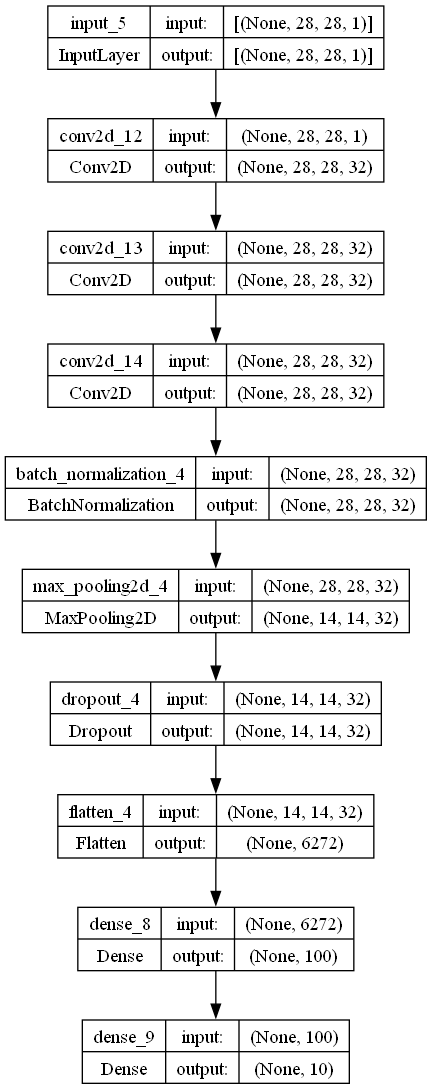

In [28]:
plot_model(model_cnn_5, to_file="model_cnn_5.png", show_shapes=True)

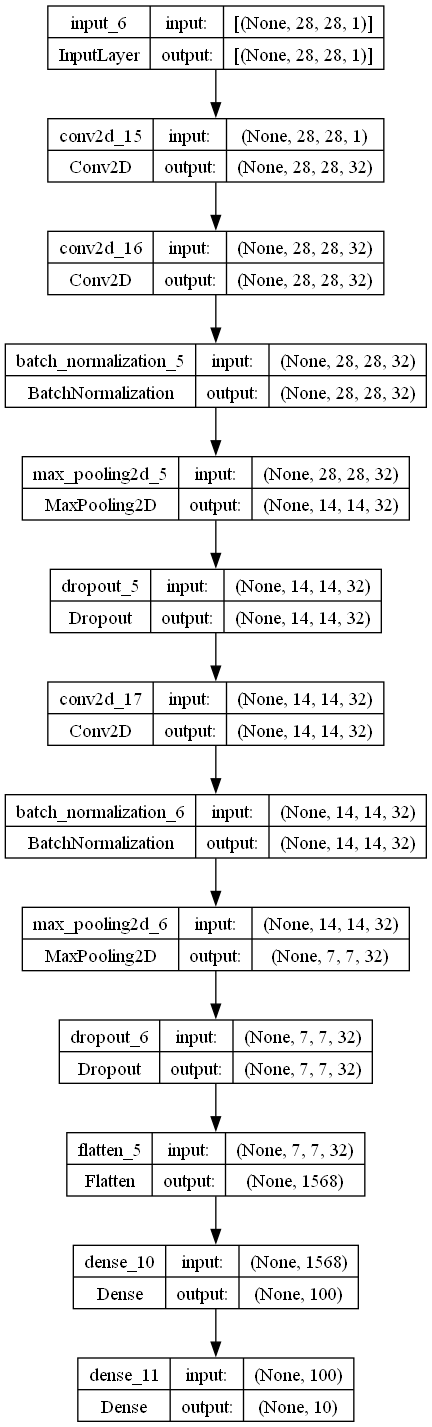

In [29]:
plot_model(model_cnn_6, to_file="model_cnn_6.png", show_shapes=True)

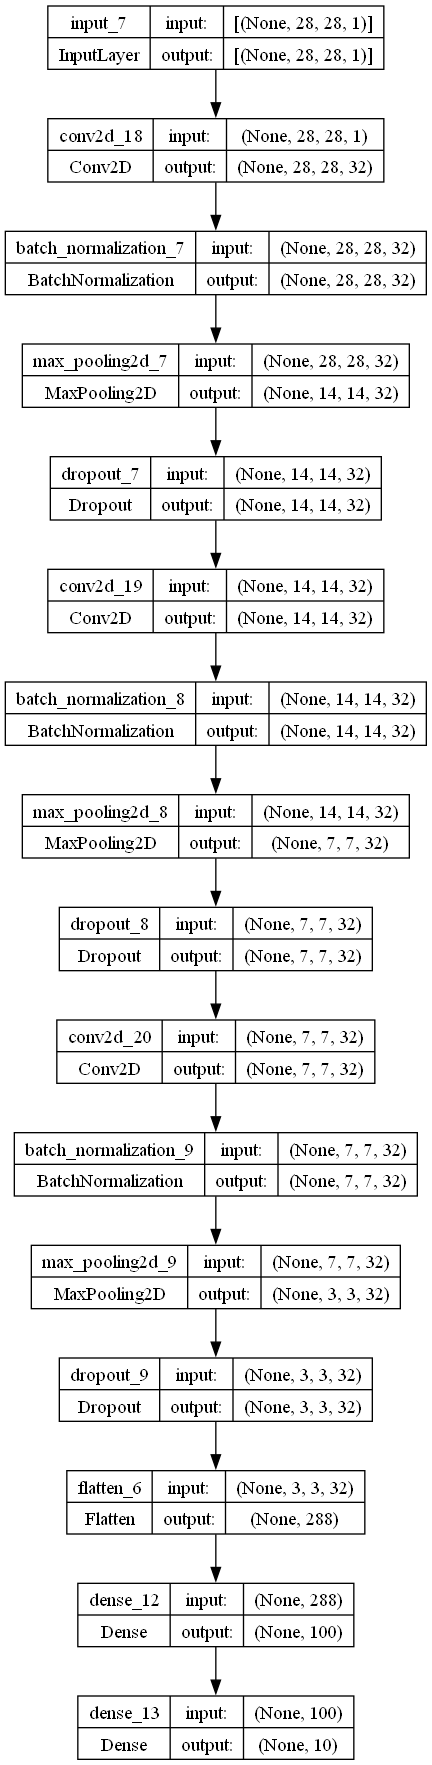

In [30]:
plot_model(model_cnn_7, to_file="model_cnn_7.png", show_shapes=True)

## 2.2. Entrenamiento de modelos

In [17]:
# Callbacks
# ModelCheckpoint guardara el modelo cada vez que exista una mejora
# en el accuracy del conjunto de validación
mode_autosave_cnn_5 = get_ckpt("classification_model_cnn_5.h5")
mode_autosave_cnn_6 = get_ckpt("classification_model_cnn_6.h5")
mode_autosave_cnn_7 = get_ckpt("classification_model_cnn_7.h5")

# EarlyStopping terminara el entrenamiento si no existe una mejora
# en el accuracy en 40 epocas
early_stopping = EarlyStopping(patience=40,
                               verbose=1,
                               mode="auto")

callbacks_cnn_5 = [mode_autosave_cnn_5, early_stopping]
callbacks_cnn_6 = [mode_autosave_cnn_6, early_stopping]
callbacks_cnn_7 = [mode_autosave_cnn_7, early_stopping]

In [18]:
history_cnn_5 = model_cnn_5.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_5
                                )

Epoch 1/200
1688/1688 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.8405
Epoch 1: val_accuracy improved from -inf to 0.86850, saving model to classification_model_cnn_5.h5
1688/1688 [==============================] - 110s 65ms/step - loss: 0.4422 - accuracy: 0.8405 - val_loss: 0.3528 - val_accuracy: 0.8685
Epoch 2/200
1688/1688 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8872
Epoch 2: val_accuracy improved from 0.86850 to 0.89900, saving model to classification_model_cnn_5.h5
1688/1688 [==============================] - 110s 65ms/step - loss: 0.3107 - accuracy: 0.8872 - val_loss: 0.2855 - val_accuracy: 0.8990
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.8989
Epoch 3: val_accuracy did not improve from 0.89900
1688/1688 [==============================] - 110s 65ms/step - loss: 0.2760 - accuracy: 0.8989 - val_loss: 0.3067 - val_accuracy: 0.8833
Epoch 4/200
1688/1688 [====================

In [19]:
history_cnn_6 = model_cnn_6.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_6
                                )

Epoch 1/200
1687/1688 [============================>.] - ETA: 0s - loss: 0.5516 - accuracy: 0.7985
Epoch 1: val_accuracy improved from -inf to 0.86850, saving model to classification_model_cnn_6.h5
1688/1688 [==============================] - 77s 45ms/step - loss: 0.5516 - accuracy: 0.7985 - val_loss: 0.3577 - val_accuracy: 0.8685
Epoch 2/200
1688/1688 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8669
Epoch 2: val_accuracy improved from 0.86850 to 0.88900, saving model to classification_model_cnn_6.h5
1688/1688 [==============================] - 76s 45ms/step - loss: 0.3630 - accuracy: 0.8669 - val_loss: 0.3166 - val_accuracy: 0.8890
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.8808
Epoch 3: val_accuracy improved from 0.88900 to 0.89400, saving model to classification_model_cnn_6.h5
1688/1688 [==============================] - 76s 45ms/step - loss: 0.3239 - accuracy: 0.8808 - val_loss: 0.2965 - val_accuracy: 0.

In [20]:
history_cnn_7 = model_cnn_7.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_7
                                )

Epoch 1/200
1688/1688 [==============================] - ETA: 0s - loss: 0.7172 - accuracy: 0.7349
Epoch 1: val_accuracy improved from -inf to 0.82967, saving model to classification_model_cnn_7.h5
1688/1688 [==============================] - 43s 25ms/step - loss: 0.7172 - accuracy: 0.7349 - val_loss: 0.4409 - val_accuracy: 0.8297
Epoch 2/200
1687/1688 [============================>.] - ETA: 0s - loss: 0.4846 - accuracy: 0.8206
Epoch 2: val_accuracy improved from 0.82967 to 0.83017, saving model to classification_model_cnn_7.h5
1688/1688 [==============================] - 42s 25ms/step - loss: 0.4844 - accuracy: 0.8206 - val_loss: 0.4435 - val_accuracy: 0.8302
Epoch 3/200
1686/1688 [============================>.] - ETA: 0s - loss: 0.4237 - accuracy: 0.8440
Epoch 3: val_accuracy improved from 0.83017 to 0.87733, saving model to classification_model_cnn_7.h5
1688/1688 [==============================] - 42s 25ms/step - loss: 0.4235 - accuracy: 0.8441 - val_loss: 0.3331 - val_accuracy: 0.

## 2.3. Visualización de los resultados del entrenamiento

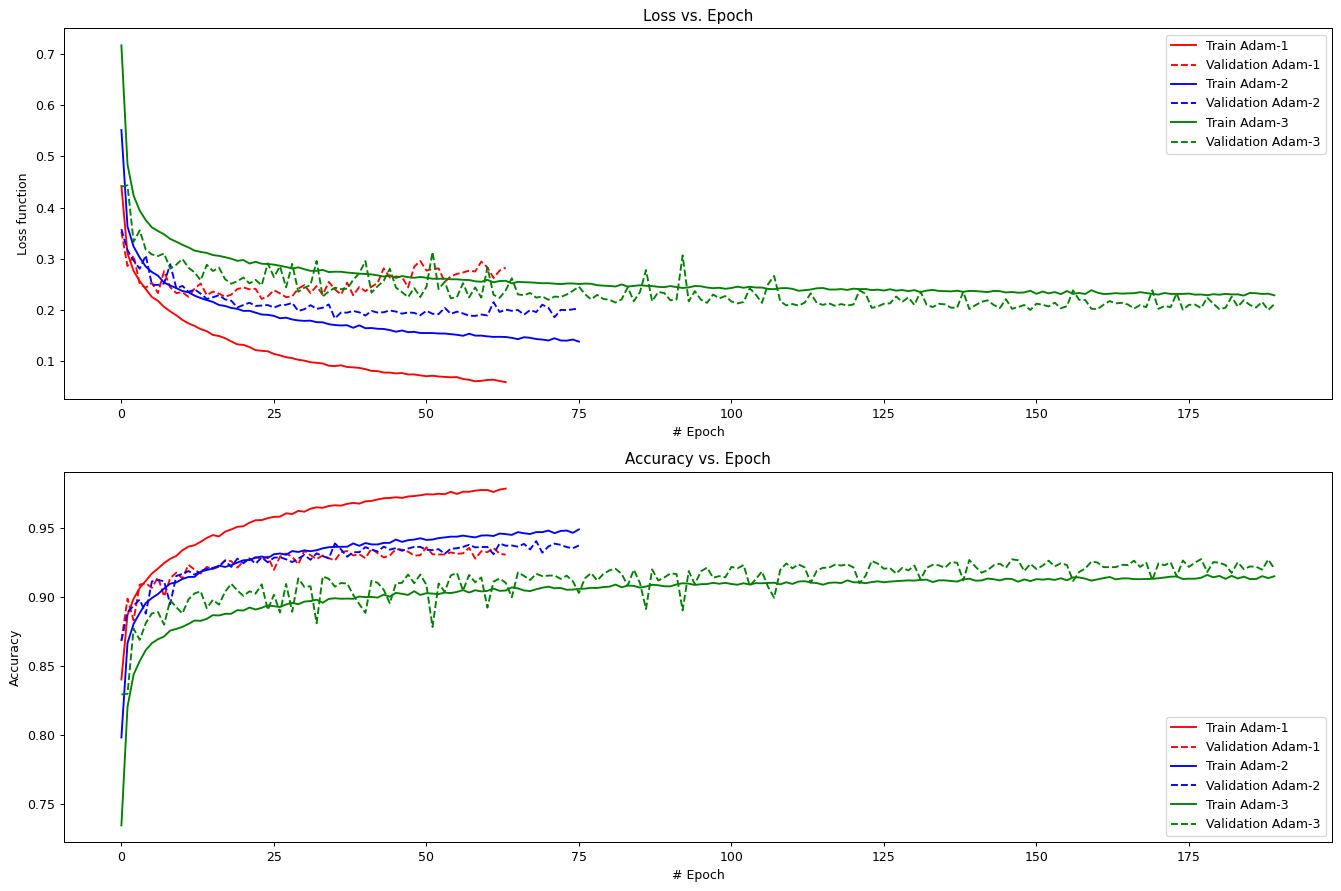

In [32]:
fig_labels = ["Train Adam-1",
              "Validation Adam-1",
              "Train Adam-2",
              "Validation Adam-2",
              "Train Adam-3",
              "Validation Adam-3"]

plt.figure(figsize=(15,10), dpi=90)

plt.subplot(2,1,1)
plt.plot(history_cnn_5.history["loss"], "r-")
plt.plot(history_cnn_5.history["val_loss"], "r--")
plt.plot(history_cnn_6.history["loss"], "b-")
plt.plot(history_cnn_6.history["val_loss"], "b--")
plt.plot(history_cnn_7.history["loss"], "g-")
plt.plot(history_cnn_7.history["val_loss"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2,1,2)
plt.plot(history_cnn_5.history["accuracy"], "r-")
plt.plot(history_cnn_5.history["val_accuracy"], "r--")
plt.plot(history_cnn_6.history["accuracy"], "b-")
plt.plot(history_cnn_6.history["val_accuracy"], "b--")
plt.plot(history_cnn_7.history["accuracy"], "g-")
plt.plot(history_cnn_7.history["val_accuracy"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.tight_layout()

plt.show()

In [ ]:
model_cnn_5.load_weights("classification_model_cnn_5.h5")
model_cnn_6.load_weights("classification_model_cnn_6.h5")
model_cnn_7.load_weights("classification_model_cnn_7.h5")

## 2.4. Resultados del modelo en la data de testeo

In [33]:
gen_test = ImageDataGenerator()

data_gen_test = gen_train.flow(x_test,
                               y_test,
                               batch_size=batch_size)

In [34]:
print("Entrenamiento:")
scores_train_5 = model_cnn_5.evaluate(data_gen_train)
scores_train_6 = model_cnn_6.evaluate(data_gen_train)
scores_train_7 = model_cnn_7.evaluate(data_gen_train)

print("Validación:")
scores_val_5 = model_cnn_5.evaluate(data_gen_val)
scores_val_6 = model_cnn_6.evaluate(data_gen_val)
scores_val_7 = model_cnn_7.evaluate(data_gen_val)

print("Pruebas:")
scores_test_5 = model_cnn_5.evaluate(data_gen_test)
scores_test_6 = model_cnn_6.evaluate(data_gen_test)
scores_test_7 = model_cnn_7.evaluate(data_gen_test)


Entrenamiento:
1688/1688 [==============================] - 16s 9ms/step - loss: 0.1724 - accuracy: 0.9362
Validación:
188/188 [==============================] - 2s 10ms/step - loss: 0.2112 - accuracy: 0.9207
Pruebas:
313/313 [==============================] - 3s 9ms/step - loss: 0.2271 - accuracy: 0.9165


In [64]:
train2 = [
    [model_cnn_5.name, scores_train_5[0], scores_train_5[1]],
    [model_cnn_6.name, scores_train_6[0], scores_train_6[1]],
    [model_cnn_7.name, scores_train_7[0], scores_train_7[1]],
]

val2 = [
    [model_cnn_5.name, scores_val_5[0], scores_val_5[1]],
    [model_cnn_6.name, scores_val_6[0], scores_val_6[1]],
    [model_cnn_7.name, scores_val_7[0], scores_val_7[1]],
]

test2 = [
    [model_cnn_5.name, scores_test_5[0], scores_test_5[1]],
    [model_cnn_6.name, scores_test_6[0], scores_test_6[1]],
    [model_cnn_7.name, scores_test_7[0], scores_test_7[1]],
]
# Defining headers
headers2 = ["Model", "Loss", "Accuracy"]

# Printing the table
print("Results in train data")
print(tabulate(train2, headers2))
print('\n')

# Printing the table
print("Results in validation data")
print(tabulate(val2, headers2))
print('\n')

# Printing the table
print("Results in test data")
print(tabulate(test2, headers2))

Results in train data
Model            Loss    Accuracy
----------  ---------  ----------
CNN_Adam_1  0.0366158    0.987167
CNN_Adam_2  0.0934997    0.965241
CNN_Adam_3  0.172449     0.936204


Results in validation data
Model           Loss    Accuracy
----------  --------  ----------
CNN_Adam_1  0.282493    0.930833
CNN_Adam_2  0.202631    0.9375
CNN_Adam_3  0.211172    0.920667


Results in test data
Model           Loss    Accuracy
----------  --------  ----------
CNN_Adam_1  0.32087       0.924
CNN_Adam_2  0.213271      0.9305
CNN_Adam_3  0.227114      0.9165


## 2.5 Resultados finales
Como se puede observar de las tablas previas, el modelo con mayor accuracy y menor loss es el modelo que cuenta con dos capas convolucionales seguidas y luego una capa convolucional final. 
Adicionalmente, se puede observar que posiblemente el modelo con la estructura de 3 capas convolucionales seguidas sufrió de overfitting pues el accuracy en la data de entrenamiento fue cercana al 99% (el mayor accuracy en entrenamiento), mientras que en la data de validación y prueba tuvo un significativamente menor (accuracy de 92% y loss de 32%)

# 3. Variantes por Learning rate

In [66]:
model_cnn_8 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_Adam_LR_0.0025",
                              optimizer="Adam",
                              learning_rate=0.0025,
                              structure=1,
                              batch_norm=True,
                              dropout=0.3)

model_cnn_9 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_Adam_LR_0.005",
                              optimizer="Adam",
                              learning_rate=0.005,
                              structure=1,
                              batch_norm=True,
                              dropout=0.3)

model_cnn_10 = get_model_funct(filters=[32, 32, 32],
                              n_classes=n_classes,
                              name="CNN_Adam_LR_0.01",
                              optimizer="Adam",
                              learning_rate=0.01,
                              structure=1,
                              batch_norm=True,
                              dropout=0.3)

## 3.1. Visualización de modelos

In [ ]:
plot_model(model_cnn_8, to_file="model_cnn_8.png", show_shapes=True)

In [ ]:
plot_model(model_cnn_9, to_file="model_cnn_9.png", show_shapes=True)

In [ ]:
plot_model(model_cnn_10, to_file="model_cnn_10.png", show_shapes=True)

## 3.2. Entrenamiento de modelos

In [44]:
# Callbacks
# ModelCheckpoint guardara el modelo cada vez que exista una mejora
# en el accuracy del conjunto de validación
mode_autosave_cnn_8 = get_ckpt("classification_model_cnn_8.h5")
mode_autosave_cnn_9 = get_ckpt("classification_model_cnn_9.h5")
mode_autosave_cnn_10 = get_ckpt("classification_model_cnn_10.h5")

# EarlyStopping terminara el entrenamiento si no existe una mejora
# en el accuracy en 40 epocas
early_stopping = EarlyStopping(patience=40,
                               verbose=1,
                               mode="auto")

callbacks_cnn_8 = [mode_autosave_cnn_8, early_stopping]
callbacks_cnn_9 = [mode_autosave_cnn_9, early_stopping]
callbacks_cnn_10 = [mode_autosave_cnn_10, early_stopping]

In [45]:
history_cnn_8 = model_cnn_8.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_8
                                )

Epoch 1/200
1688/1688 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.8208
Epoch 1: val_accuracy improved from -inf to 0.86150, saving model to classification_model_cnn_8.h5
1688/1688 [==============================] - 107s 63ms/step - loss: 0.4932 - accuracy: 0.8208 - val_loss: 0.3726 - val_accuracy: 0.8615
Epoch 2/200
1688/1688 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8710
Epoch 2: val_accuracy improved from 0.86150 to 0.86767, saving model to classification_model_cnn_8.h5
1688/1688 [==============================] - 109s 65ms/step - loss: 0.3541 - accuracy: 0.8710 - val_loss: 0.3600 - val_accuracy: 0.8677
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8852
Epoch 3: val_accuracy improved from 0.86767 to 0.89167, saving model to classification_model_cnn_8.h5
1688/1688 [==============================] - 112s 66ms/step - loss: 0.3112 - accuracy: 0.8852 - val_loss: 0.2994 - val_accuracy:

In [46]:
history_cnn_9 = model_cnn_9.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_9
                                )

Epoch 1/200
1688/1688 [==============================] - ETA: 0s - loss: 0.5142 - accuracy: 0.8136
Epoch 1: val_accuracy improved from -inf to 0.85500, saving model to classification_model_cnn_9.h5
1688/1688 [==============================] - 109s 64ms/step - loss: 0.5142 - accuracy: 0.8136 - val_loss: 0.3880 - val_accuracy: 0.8550
Epoch 2/200
1688/1688 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.8599
Epoch 2: val_accuracy improved from 0.85500 to 0.87600, saving model to classification_model_cnn_9.h5
1688/1688 [==============================] - 111s 66ms/step - loss: 0.3827 - accuracy: 0.8599 - val_loss: 0.3533 - val_accuracy: 0.8760
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8694
Epoch 3: val_accuracy improved from 0.87600 to 0.88100, saving model to classification_model_cnn_9.h5
1688/1688 [==============================] - 110s 65ms/step - loss: 0.3585 - accuracy: 0.8694 - val_loss: 0.3264 - val_accuracy:

In [47]:
history_cnn_10 = model_cnn_10.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_10
                                )

Epoch 1/200
1688/1688 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.7622
Epoch 1: val_accuracy improved from -inf to 0.78517, saving model to classification_model_cnn_10.h5
1688/1688 [==============================] - 108s 63ms/step - loss: 0.6563 - accuracy: 0.7622 - val_loss: 0.6048 - val_accuracy: 0.7852
Epoch 2/200
1688/1688 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.8166
Epoch 2: val_accuracy improved from 0.78517 to 0.79250, saving model to classification_model_cnn_10.h5
1688/1688 [==============================] - 106s 63ms/step - loss: 0.5062 - accuracy: 0.8166 - val_loss: 0.6279 - val_accuracy: 0.7925
Epoch 3/200
1688/1688 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8319
Epoch 3: val_accuracy improved from 0.79250 to 0.80700, saving model to classification_model_cnn_10.h5
1688/1688 [==============================] - 106s 63ms/step - loss: 0.4773 - accuracy: 0.8319 - val_loss: 0.5655 - val_accura

## 3.3. Visualización de los resultados del entrenamiento

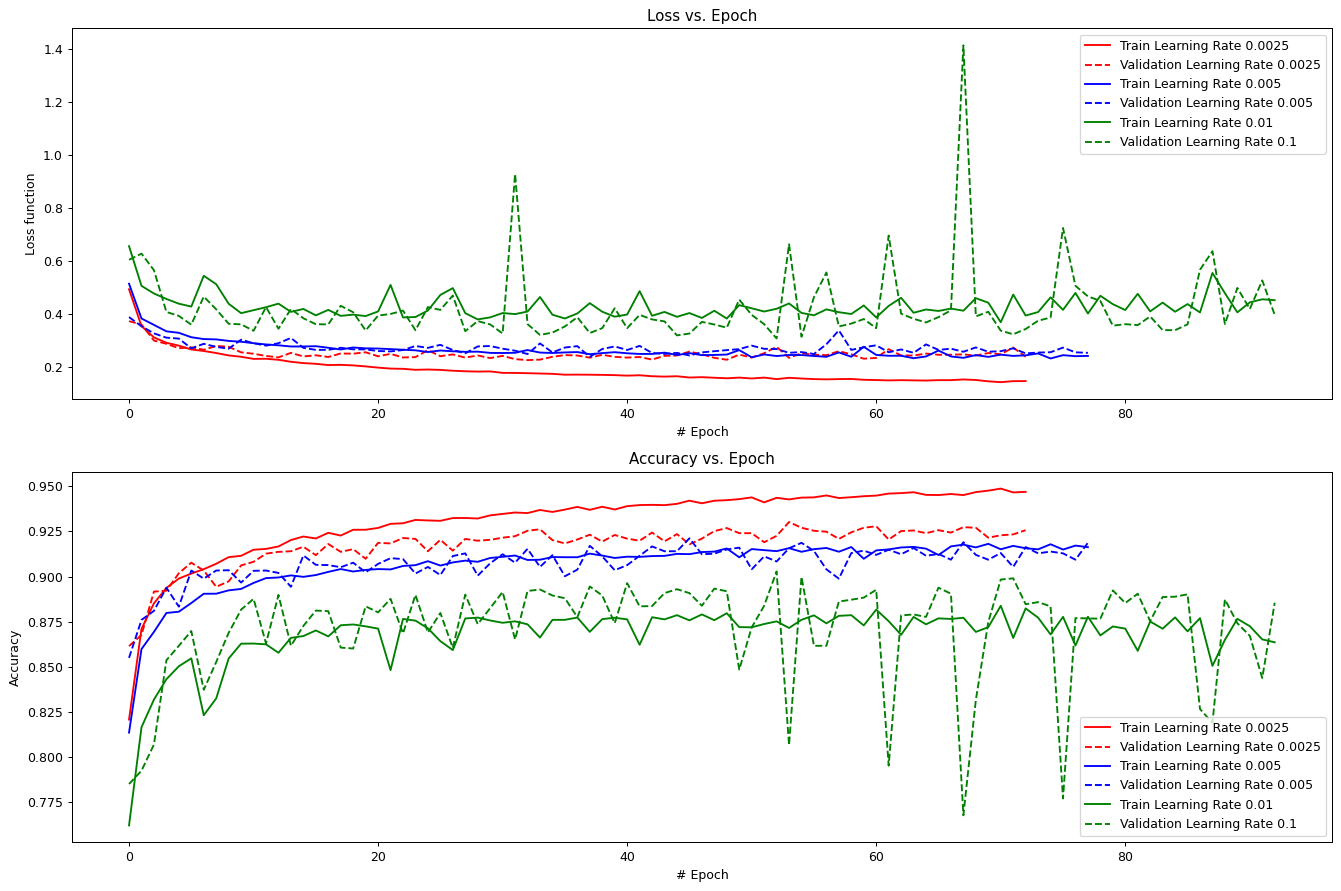

In [49]:
fig_labels = ["Train Learning Rate 0.0025",
              "Validation Learning Rate 0.0025",
              "Train Learning Rate 0.005",
              "Validation Learning Rate 0.005",
              "Train Learning Rate 0.01",
              "Validation Learning Rate 0.1"]

plt.figure(figsize=(15,10), dpi=90)

plt.subplot(2,1,1)
plt.plot(history_cnn_8.history["loss"], "r-")
plt.plot(history_cnn_8.history["val_loss"], "r--")
plt.plot(history_cnn_9.history["loss"], "b-")
plt.plot(history_cnn_9.history["val_loss"], "b--")
plt.plot(history_cnn_10.history["loss"], "g-")
plt.plot(history_cnn_10.history["val_loss"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2,1,2)
plt.plot(history_cnn_8.history["accuracy"], "r-")
plt.plot(history_cnn_8.history["val_accuracy"], "r--")
plt.plot(history_cnn_9.history["accuracy"], "b-")
plt.plot(history_cnn_9.history["val_accuracy"], "b--")
plt.plot(history_cnn_10.history["accuracy"], "g-")
plt.plot(history_cnn_10.history["val_accuracy"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.tight_layout()

plt.show()

## 3.4. Resultados de los modelos en la data de testeo

In [50]:
gen_test = ImageDataGenerator()

data_gen_test = gen_train.flow(x_test,
                               y_test,
                               batch_size=batch_size)

In [51]:
print("Entrenamiento:")
scores_train_5 = model_cnn_5.evaluate(data_gen_train)
scores_train_8 = model_cnn_8.evaluate(data_gen_train)
scores_train_9 = model_cnn_9.evaluate(data_gen_train)
scores_train_10 = model_cnn_10.evaluate(data_gen_train)

print("Validación:")
scores_val_5 = model_cnn_5.evaluate(data_gen_val)
scores_val_8 = model_cnn_8.evaluate(data_gen_val)
scores_val_9 = model_cnn_9.evaluate(data_gen_val)
scores_val_10 = model_cnn_10.evaluate(data_gen_val)

print("Pruebas:")
scores_test_5 = model_cnn_5.evaluate(data_gen_test)
scores_test_8 = model_cnn_8.evaluate(data_gen_test)
scores_test_9 = model_cnn_9.evaluate(data_gen_test)
scores_test_10 = model_cnn_10.evaluate(data_gen_test)


Entrenamiento:
1688/1688 [==============================] - 24s 14ms/step - loss: 0.3320 - accuracy: 0.8970
Validación:
188/188 [==============================] - 3s 14ms/step - loss: 0.3965 - accuracy: 0.8855
Pruebas:
313/313 [==============================] - 4s 14ms/step - loss: 0.3987 - accuracy: 0.8856


In [67]:
train3 = [
    [model_cnn_8.name, scores_train_8[0], scores_train_8[1]],
    [model_cnn_9.name, scores_train_9[0], scores_train_9[1]],
    [model_cnn_10.name, scores_train_10[0], scores_train_10[1]],
]

val3 = [
    [model_cnn_8.name, scores_val_8[0], scores_val_8[1]],
    [model_cnn_9.name, scores_val_9[0], scores_val_9[1]],
    [model_cnn_10.name, scores_val_10[0], scores_val_10[1]],
]

test3 = [
    [model_cnn_8.name, scores_test_8[0], scores_test_8[1]],
    [model_cnn_9.name, scores_test_9[0], scores_test_9[1]],
    [model_cnn_10.name, scores_test_10[0], scores_test_10[1]],
]
# Defining headers
headers3 = ["Model", "Loss", "Accuracy"]

# Printing the table
print("Results in train data")
print(tabulate(train3, headers3))
print('\n')

# Printing the table
print("Results in validation data")
print(tabulate(val3, headers3))
print('\n')

# Printing the table
print("Results in test data")
print(tabulate(test3, headers3))

Results in train data
Model                   Loss    Accuracy
------------------  --------  ----------
CNN_Adam_LR_0.0025  0.105577    0.961519
CNN_Adam_LR_0.005   0.176612    0.936315
CNN_Adam_LR_0.01    0.332041    0.896963


Results in validation data
Model                   Loss    Accuracy
------------------  --------  ----------
CNN_Adam_LR_0.0025  0.237874    0.925667
CNN_Adam_LR_0.005   0.252928    0.918667
CNN_Adam_LR_0.01    0.396461    0.8855


Results in test data
Model                   Loss    Accuracy
------------------  --------  ----------
CNN_Adam_LR_0.0025  0.255228      0.9191
CNN_Adam_LR_0.005   0.273572      0.914
CNN_Adam_LR_0.01    0.398726      0.8856


## 3.5 Resultados finales
Como se puede observar en las tablas previas, el learning rate afecta de manera inversa al accuracy y de manera directa al loss. Esto en la medida que los modelos con un menor learning rate tienen un mayor accuracy y un menor loss en todas las muestras.

- **Deadline:** 21.10.2023
- **Archivos:** Link del Colab, o descargar el archivo (*.ipynb) y enviarlo por email, o link al repositorio en GitHub
- **E-mail:** p.diaz@tu-braunschweig.de, p.diaz@tu-bs.de (ambos son el mismo correo)